# Exploring Data from a Video Game Research Server

In [39]:
### Please run thsi cell before moving forward:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

In [40]:
players_data <- read.csv("data/players.csv")
players_data

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [41]:
seasons_data <- read.csv("data/sessions.csv")
seasons_data

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


## Data Description

#### I have chosen to work with the players dataset provided from "players.csv" 

In [42]:
number_observations <- nrow(players_data)
number_variables    <- ncol(players_data)
dimensions_players <- cat("Observations:", number_observations, 
                          " Variables:", number_variables)


Observations: 196  Variables: 7

- There are only 196 players, giving us only 196 observations to work with. **A stratified approach to training and validation might be best (i.e. 5-fold cross-validation)**.

- Two of the 7 variables provided will most likely **not be used** for any statistical analysis and modelling regardless of the question chosen. These are:
    1.  `hashedEmail`
    2.  `name`

In [43]:
statistical_summary_played_hours <- players_data |> 
    summarize(
        played_hours_mean   = round(mean(played_hours, na.rm = TRUE), 2),
        played_hours_median = round(median(played_hours, na.rm = TRUE), 2),
        played_hours_min    = round(min(played_hours, na.rm = TRUE), 2),
        played_hours_max    = round(max(played_hours, na.rm = TRUE), 2))

played_none <- players_data |>
    filter(played_hours == 0) |>
    summarize(count = n(), .groups = "drop")

statistical_summary_played_hours
played_none

played_hours_mean,played_hours_median,played_hours_min,played_hours_max
<dbl>,<dbl>,<dbl>,<dbl>
5.85,0.1,0,223.1


count
<int>
85


**Played Hours Numeric Summary:**
- Based on the values provided by the statistical summary, the data show a **right-skewed distribution**. Looking further into the dataset and calculating the number of players who played 0 hours, I suspect the reason for the right-skew is that a rather large number of players **(85 players, 43.37%) have not played the game and are included in the study**.
- This prompt me to invistage this idea via a **histogram visualization**.
- This observation also suggests that it might be interesting to ask questions about **what characteristics predict players whom might contribute significantly to the project** - assuming that this factor, **large amount of data contribution/player**, produces better results for the Pacific Team. (relating to **Question 2**)

In [44]:
statistical_summary_age <- players_data |> 
    summarize(
        age_mean            = round(mean(Age, na.rm = TRUE), 2),
        age_median          = round(median(Age, na.rm = TRUE), 2),
        age_min             = round(min(Age, na.rm = TRUE), 2),
        age_max             = round(max(Age, na.rm = TRUE), 2)) 
statistical_summary_age

age_mean,age_median,age_min,age_max
<dbl>,<dbl>,<dbl>,<dbl>
21.14,19,9,58


**Age Numeric Summary:**

- The study has some very young and very old players (outliers) but overall the age group for most participants is late teens to early twenties.


In [45]:
experience_count_per <- players_data |>
    group_by(experience) |>
    summarize(count = n(), .groups = "drop") |>
    mutate(per = round(100 * count / sum(count), 2))

experience_count_per

experience,count,per
<chr>,<int>,<dbl>
Amateur,63,32.14
Beginner,35,17.86
Pro,14,7.14
Regular,36,18.37
Veteran,48,24.49


**Experience - Categorical Composition:**

- There is a reasonable spread of experience with the smallest class being "Pro" at around 7%. **A great question and experiement to do would be to see the contribution of each class to play time and their newsletter subscription status**.

In [46]:
gender_count_per <- players_data |>
    group_by(gender) |>
    summarize(count = n(), .groups = "drop") |>
    mutate(per = round(100 * count / sum(count), 2))

gender_count_per

gender,count,per
<chr>,<int>,<dbl>
Agender,2,1.02
Female,37,18.88
Male,124,63.27
⋮,⋮,⋮
Other,1,0.51
Prefer not to say,11,5.61
Two-Spirited,6,3.06


**Gender - Categorical Composition:**

- There is a **strong class imbalance with "Male" category** coming at about **63.27%**. Given what we know about how many players have played 0 hours and the rather large imbalance towards "Male", **it's imparative to check what the contributation of this class to the study per instance**. *My hypothesis is that many male players have signed up but did not engage with the game and study suggesting an explanation to the large 0 hours played spike*.
- The category is also **noisy due to it being self-reported** and given that "Other" and "Prefer not to say" are present instead of contributing to the present categories or contributing to gender categories not represented in the population on the surface.

In [47]:
subscription_status <- players_data |>
    group_by(subscribe) |>
    summarize(count = n(), .groups = "drop") |>
    mutate(per = round(100 * count / sum(count), 2))

subscription_status

subscribe,count,per
<lgl>,<int>,<dbl>
FALSE,52,26.53
TRUE,144,73.47


**Subscription Status - Categorical Composition:**

- There is a **strong imbalance towards "TRUE"** which suggests a strong interest in the experiment. However, **since subscription status can be thought of as a proxy for interest, one should examine the relationship between subscription status and contribution to the experiment (playing time)** as you would *expect* newsletter subscribers to have higher playing hours on average.

## Questions

**The Questions:**

- **Broad Question (#2)**: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.
- **Specific question: Can player's age, gender, and experience predict whether they are in the top 25% of total play time?** (whether they are going to contribute significantly to the experiement or not.)

**More About The Choice:**

- Since I saw that the newsletter subscribers category is **not a good proxy of contribution and is rather a proxy for interest**. I wanted to examine how the experiments stakeholders can **improve their recruitment practices to get more players who can contribute more significantly to their project without inducing bias** to their selection process.
- I have chosen top 25% as to present this data into **four quartiles**, this makes it easier to communicate the significance of the result (if any) to the stakeholders. I also cannot chose a random cuttoff for played_time (say at an hour) as it has no innate meaning neither does it relate to the dataset in a meaningful manner.

**How The Data Helps Answer The Question:**

- Due to proposing using quartile-based definition for heavy contributors, (with heavy contributor defined as someone in the top 25% of `played_hours`), age, gender, and experience can be used to predict a binary label response variable. In this case, the explanatory variables serve in our prediction model but also allow the stakeholders to better formulate targeted recruiting.

**Wrangling Plan:**

1. Will be creating a label `heavy_contributor` and will assign it a binary value of 1 given that the player is in the top quratile of contributors.
2. Will handle any missing cells for all explanatory variables and the response variable.
3. Will not be using the following variables `name` and `hashedEmail` and so will be dropping them to tidy the dataset further.
4. Will regroup non-Male/non-Female gender levels into `Other` to stabilize the variable.
5. Will split the data into training and testing data sets, with the split going 80:20 as this gives the model ~10 true positive cases of `heavy_contributor`.
6. Will stratify the training data using 5-fold cross-validation.

## Exploratory Data Analysis and Visualization

### Mean Value Calculations

In [48]:
quantitative_variables <- players_data |>
    select(where(is.numeric))

mean_value_table <- quantitative_variables |>
    summarize(
        across(.cols = everything(),
               ~ round(mean(.x, na.rm = TRUE), 2))
    )

# quantitative_variables
mean_value_table

played_hours,Age
<dbl>,<dbl>
5.85,21.14


### Visualizations and Further Analysis

#### Heavy Contributors Distribution

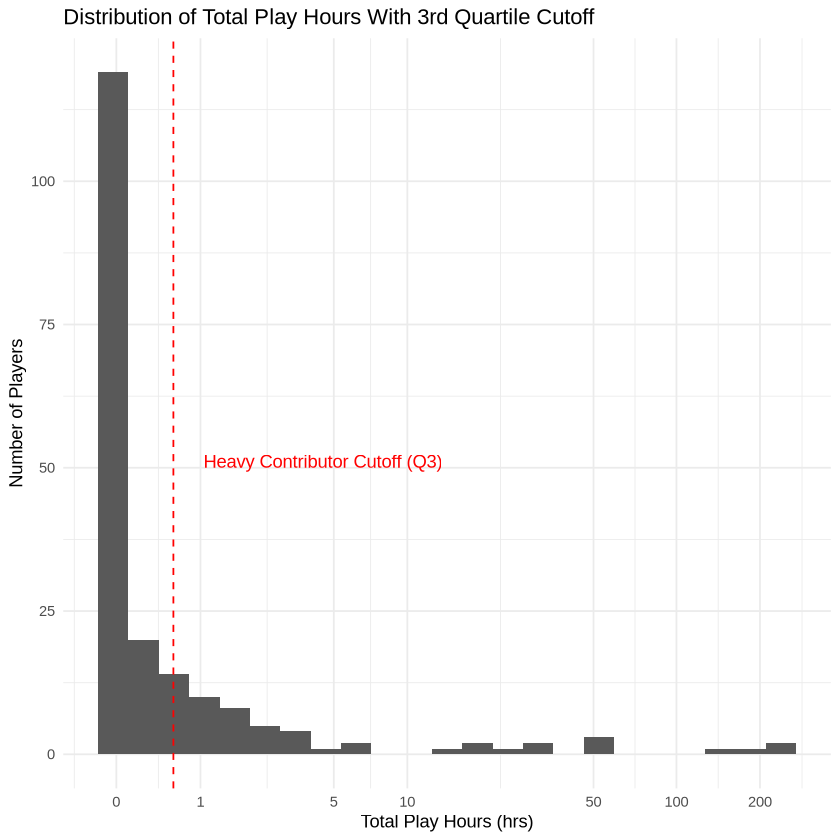

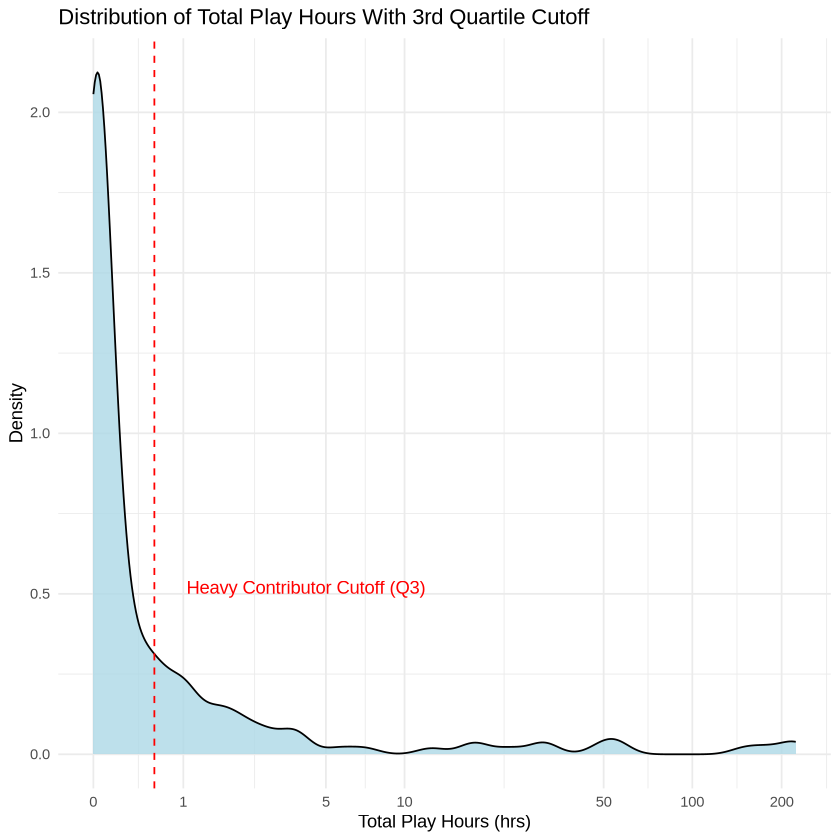

In [56]:
quartile_3rd_cutoff <- players_data |>
    summarize(quartile_3rd = quantile(played_hours, 0.75, na.rm = TRUE)) |>
    pull(quartile_3rd)

# quartile_3rd_cutoff #the 75th percentile is about 0.6 hours = 26 minutes.

players_data_heavy <- players_data |>
    mutate(heavy_contributor = factor(played_hours >= quartile_3rd_cutoff,
                                      levels = c(FALSE, TRUE),
                                      labels = c("No", "Yes")))

# players_data_heavy

heavy_histogram <- players_data_heavy |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(
        binwidth = 0.25, 
        boundary = quartile_3rd_cutoff, 
        closed = "left") +
    geom_vline(
        xintercept = quartile_3rd_cutoff, 
        linetype = "dashed", 
        color = "red") +
    scale_x_continuous(
        trans = "log1p",
        breaks = c(0, 1, 5, 10, 50, 100, 200))+
    annotate(
        "text", x = 1.05, y = 50, 
        label = "Heavy Contributor Cutoff (Q3)",
        hjust = 0, vjust = 0, colour = "red") +
    labs(
        x = "Total Play Hours (hrs)",
        y = "Number of Players",
        title = "Distribution of Total Play Hours With 3rd Quartile Cutoff") +
    theme_minimal()

heavy_density_plot <- players_data_heavy |>
    ggplot(aes(x = played_hours)) +
    geom_density(fill = "lightblue", alpha = 0.8) + 
    geom_vline(
        xintercept = quartile_3rd_cutoff,  
        linetype = "dashed",  
        color = "red") +
    scale_x_continuous(
        trans = "log1p",
        breaks = c(0, 1, 5, 10, 50, 100, 200)) +
    annotate(
        "text", x = 1.05, y = 0.5, 
        label = "Heavy Contributor Cutoff (Q3)",
        hjust = 0, vjust = 0, colour = "red") +
    labs(
        x = "Total Play Hours (hrs)",
        y = "Density",  
        title = "Distribution of Total Play Hours With 3rd Quartile Cutoff") +
    theme_minimal()

heavy_histogram
heavy_density_plot


- These distribution graphs (histograph and density plot) demonstrate the current recruitment problem that is faced by the stakehodlers, the vast majorty of players contribute nothing or close to nothing in play time and only few players contribute heavly towards the experiment. 

- The graphs illustrate a need for solving this issue and bridging the gap by aiming to fill the breaks between the local contribution areas (bars) and flatten the huge 0-play time spike skewing the graph towards one end over the other. 

#### Gender Category Regrouped

In [88]:

players_data_heavy <- players_data_heavy |>
  mutate(
    gender_group = case_when(
        gender == "Male"   ~ "Male",
        gender == "Female" ~ "Female",
        # then group everything else, basically!
        TRUE               ~ "Other"),
    gender_group = factor(gender_group,
                          levels = c("Male", "Female", "Other")))

# players_data_heavy

#### Heavy Contributors Share By Group

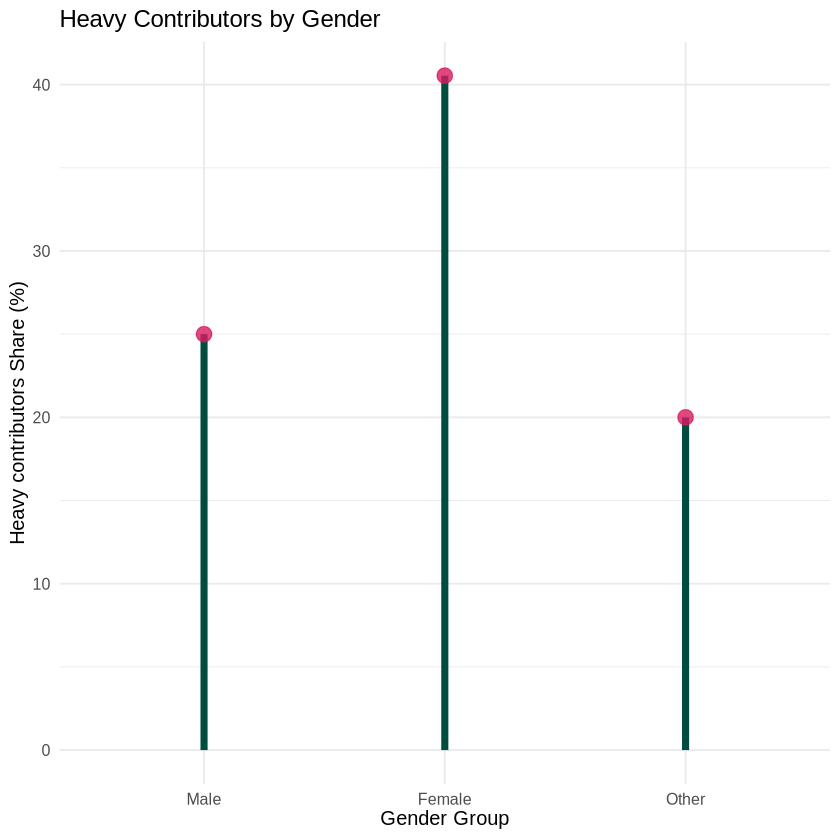

In [87]:
# By Gender
heavy_contributor_by_gender <- players_data_heavy |>
    group_by(gender_group) |>
    summarize(contributor_total = n(),
            heavy_total = sum(heavy_contributor == "Yes"),
            heavy_per = round(100 * heavy_total / contributor_total, 2),
            .groups = "drop")

# heavy_contributor_by_gender
# By Gender Plot:

## ** THIS PLOT WON'T WORK ** ##

# heavy_contributor_by_gender_plot <- heavy_contributor_by_gender |>
#     ggplot(aes(x = gender_group, y = heavy_per, color = heavy_per)) +
#     geom_point(alpha = 0.4) +
#     labs(
#         x = "Gender Group (Male, Female, Other)",
#         y = "Heavy Contributors Share (%)",
#         title = "Heavy Contributors by Experience"
#         ) +
#     scale_color_gradientn(
#         colors = c("#004D40", "#1E88E5", "#D81B60"),
#         limits = c(0, 100),
#         name = "Heavy share (%)"
#         ) +
#     theme_minimal(base_size = 12)

# heavy_contributor_by_gender_plot


heavy_contributor_by_gender_plot <- heavy_contributor_by_gender |>
    ggplot(aes(x = gender_group, y = heavy_per)) +
    geom_segment(aes(xend = gender_group, y = 0, yend = heavy_per),
                 color = "#004D40", linewidth = 2) +
    geom_point(alpha = 0.8, size = 4, color = "#D81B60") +
    labs(
        title = "Heavy Contributors by Gender ",
        x = "Gender Group", 
        y = "Heavy contributors Share (%)"
        ) +
    theme_minimal(base_size = 12)

heavy_contributor_by_gender_plot

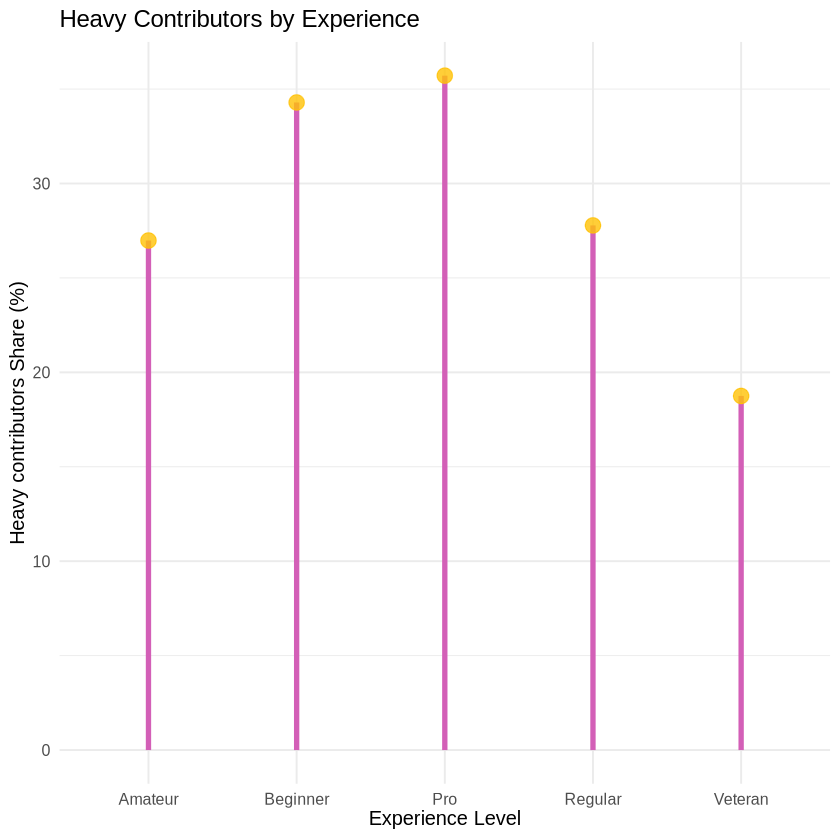

In [92]:

# By Experience 
heavy_contributor_by_experience <- players_data_heavy |>
    group_by(experience) |>
    summarize(contributor_total = n(),
            heavy_total = sum(heavy_contributor == "Yes"),
            heavy_per = round(100 * heavy_total / contributor_total, 2),
            .groups = "drop")

# heavy_contributor_by_experience
# By Experience Plot:

## ** THIS PLOT WON'T WORK ** ##

# heavy_contributor_by_experience_plot <- heavy_contributor_by_experience |>
#     ggplot(aes(x = experience, y = heavy_per, color = heavy_per)) +
#     geom_point(alpha = 0.4) +
#     labs(
#         x = "Experience Level",
#         y = "Heavy Contributors Share (%)",
#         title = "Heavy Contributors by Experience"
#         ) +
#     scale_color_gradientn(
#         colors = c("#004D40", "#1E88E5", "#D81B60"),
#         limits = c(0, 100),
#         name = "Heavy share (%)"
#         ) +
#     theme_minimal(base_size = 12)

# heavy_contributor_by_experience_plot


heavy_contributor_by_experience_plot <- heavy_contributor_by_experience |>
    ggplot(aes(x = experience, y = heavy_per)) +
    geom_segment(aes(xend = experience, y = 0, yend = heavy_per),
                 color = "#D35FB7", linewidth = 1.5) +
    geom_point(alpha = 0.8, size = 4, color = "#FFC107") +
    labs(
        title = "Heavy Contributors by Experience ",
        x = "Experience Level", 
        y = "Heavy contributors Share (%)"
        ) +
    theme_minimal(base_size = 12)

heavy_contributor_by_experience_plot

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


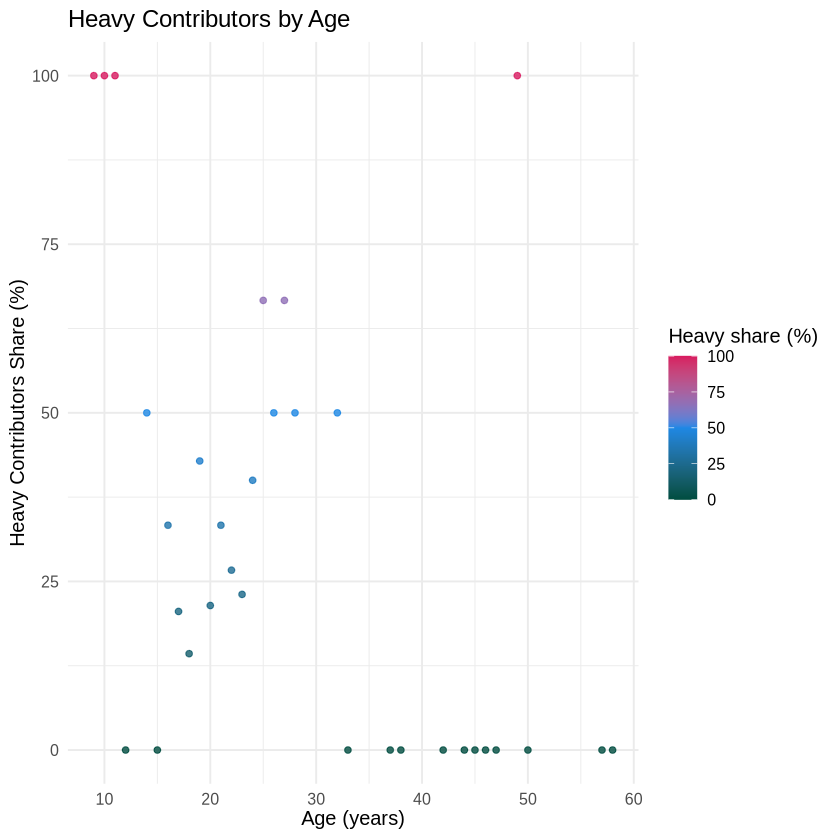

In [93]:

# By Age 
heavy_contributor_by_age <- players_data_heavy |>
    group_by(Age) |>
    summarize(contributor_total = n(),
            heavy_total = sum(heavy_contributor == "Yes"),
            heavy_per = round(100 * heavy_total / contributor_total, 2),
            .groups = "drop")

# heavy_contributor_by_age
# By Age Plot:
heavy_contributor_by_age_plot <- heavy_contributor_by_age |>
    ggplot(aes(x = Age, y = heavy_per, color = heavy_per)) +
    geom_point(alpha = 0.8) +
    labs(
        x = "Age (years)",
        y = "Heavy Contributors Share (%)",
        title = "Heavy Contributors by Age"
        ) +
    scale_color_gradientn(
        colors = c("#004D40", "#1E88E5", "#D81B60"),  # dark blue → blue → orange
        limits = c(0, 100),
        name = "Heavy share (%)"
        ) +
    theme_minimal(base_size = 12)

heavy_contributor_by_age_plot

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


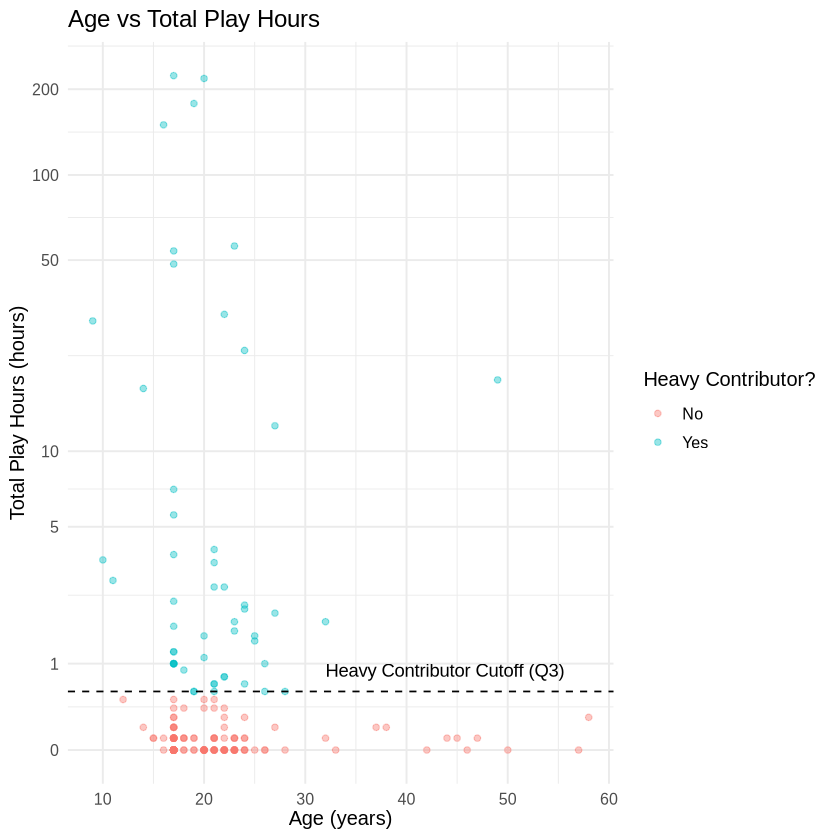

In [51]:
p3 <- ggplot(players_data_heavy, aes(x = Age, y = played_hours, color = heavy_contributor)) +
    geom_point(alpha = 0.4) +
    geom_hline(
        yintercept = quartile_3rd_cutoff,
               linetype = "dashed",
               color = "black") +
    scale_y_continuous(
        trans = "log1p",
        breaks = c(0,1,5,10,50,100,200)) +
    labs(title = "Age vs Total Play Hours",
         x = "Age (years)", 
         y = "Total Play Hours (hours)",
         color = "Heavy Contributor?") +
    annotate(
        "text", x = 32, y = 0.8, 
        label = "Heavy Contributor Cutoff (Q3)",
        hjust = 0, vjust = 0, colour = "black") +
    theme_minimal(base_size = 12)

p3